In [145]:
import csv
import numpy as np
import matplotlib.pyplot as plt

In [44]:
# データの読み込み
gallery_action_fvs = np.load("/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/trecvid_2019/gallery/action_features.npy")
gallery_person_fvs = np.load("/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/trecvid_2019/gallery/person_features.npy")
query_action_fvs = np.load("/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/trecvid_2019/query/action_features.npy")
query_person_fvs = np.load("/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/trecvid_2019/query/person_features.npy")

In [114]:
query_action_label = '1'
query_person_label = '8'

# クエリの読み込み
with open("/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/trecvid_2019/query/features.csv", "r") as f:
    rows = csv.reader(f, delimiter=" ")
    query_list = [r for r in rows if r[6] == query_action_label and r[7] == query_person_label]
    
query_action_idx_list = list(set([int(q[3]) for q in query_list]))
query_person_idx_list = list(set([int(q[4]) for q in query_list]))

In [115]:
# コサイン類似度
def cosine_similarity(query_fv, gallery_fvs):
    sim_list = np.array([np.dot(query_fv, gallery_fv) for gallery_fv in gallery_fvs])
    return np.argsort(-sim_list)

In [116]:
# L2 類似度
def l2_similarity(query_fv, gallery_fvs):
    sim_list = np.array([np.sum((query_fv - gallery_fv) ** 2) for gallery_fv in gallery_fvs])
    return np.argsort(sim_list)

In [117]:
# AP の計算
def calc_ap(gt_label, gallery_labels):
    total_num = 0
    correct_num = 0
    precision_sum = 0.0
    
    for gallery_label in gallery_labels:
        total_num += 1
        if gallery_label == gt_label:
            correct_num += 1
            precision_sum += correct_num / total_num
           
    ap = precision_sum / correct_num
    return ap

In [118]:
# 手作業でアノテーションをつけた映像のデータ
action_fvs = []
person_fvs = []
action_labels = []
person_labels = []
action_video_paths = []
person_video_paths = []
person_action_idxes = []
person_action_labels = []
with open("./features.csv", "r") as f:
    rows = csv.reader(f, delimiter=" ")
    for row in rows:
        _, _, _, action_idx, person_idx, video_path, action_label, person_label = row
        person_fvs.append(gallery_person_fvs[int(person_idx)])
        person_labels.append(int(person_label))
        person_video_paths.append(video_path)
        person_action_idxes.append(int(action_idx))
        person_action_labels.append(int(action_label))
        if person_label == query_person_label:
            action_fvs.append(gallery_action_fvs[int(action_idx)])
            action_labels.append(int(action_label))
            action_video_paths.append(video_path)

action_fvs = np.array(action_fvs)
person_fvs = np.array(person_fvs)

In [156]:
# 動作による映像検索
mAP = 0.0
for idx in query_action_idx_list:
    print("Query index : ", idx)
    query_fv = query_action_fvs[idx]
    idx_rankings = l2_similarity(query_fv, action_fvs)
    label_rankings = [action_labels[idx] for idx in idx_rankings]
    path_rankings = [action_video_paths[idx] for idx in idx_rankings]
    ap = calc_ap(int(query_action_label), label_rankings)
    print("AP : ", ap)
    print(label_rankings[:10])
    print(path_rankings[:10])
    print()
    mAP += ap
    if idx == 0:
        break
print("mAP : ", mAP / len(query_action_idx_list))

Query index :  0
AP :  0.11045219730208569
[99, 99, 1, 99, 99, 99, 99, 1, 99, 1]
['/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detected/shot155_838_id_1656133.mp4', '/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detected/shot155_736_id_1655700.mp4', '/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detected/shot74_467_id_836622.mp4', '/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detected/shot109_1426_id_1182236.mp4', '/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detected/shot169_1390_id_1808241.mp4', '/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detected/shot190_381_id_2010346.mp4', '/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detected/shot184_917_id_1943087.mp4', '/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detected/shot37_905_id_403897.mp4', '/net/per610a/export/das18a/satoh-lab/share/datasets/eas

<BarContainer object of 34 artists>

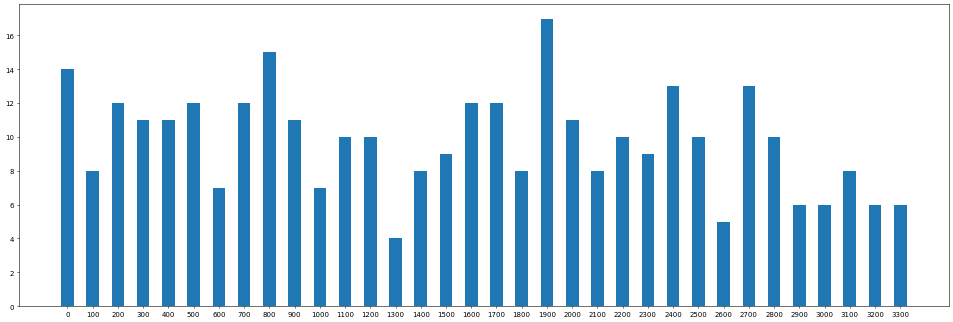

In [157]:
x = [i for i in range(0, len(label_rankings), 100)]
y = []
for i in x:
    cnt = 0
    for l in label_rankings[i:i+100]:
        if l == 1:
            cnt += 1
    y.append(cnt)

plt.figure(figsize=(24, 8), dpi=50)
plt.bar([str(i) for i in x], y, width=0.5)

In [148]:
# 人物による映像検索
mAP = 0.0
for idx in query_person_idx_list:
    print("Query index : ", idx)
    query_fv = query_person_fvs[idx]
    idx_rankings = cosine_similarity(query_fv, person_fvs)
    label_rankings = [person_labels[idx] for idx in idx_rankings]
    path_rankings = [person_video_paths[idx] for idx in idx_rankings]
    ap = calc_ap(int(query_person_label), label_rankings)
    print("AP : ", ap)
    print(label_rankings[:10])
    print(path_rankings[:10])
    print()
    mAP += ap
    if idx == 29:
        break
print("mAP : ", mAP / len(query_person_idx_list))

Query index :  28
AP :  0.3735107624218803
[8, 0, 8, 8, 0, 8, 8, 0, 8, 0]
['/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detected/shot128_325_id_1369654.mp4', '/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detected/shot55_1570_id_624798.mp4', '/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detected/shot127_37_id_1357592.mp4', '/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detected/shot30_1552_id_325544.mp4', '/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detected/shot54_869_id_609871.mp4', '/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detected/shot89_860_id_995856.mp4', '/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detected/shot26_22_id_273266.mp4', '/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detected/shot1_574_id_14623.mp4', '/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detec

<BarContainer object of 98 artists>

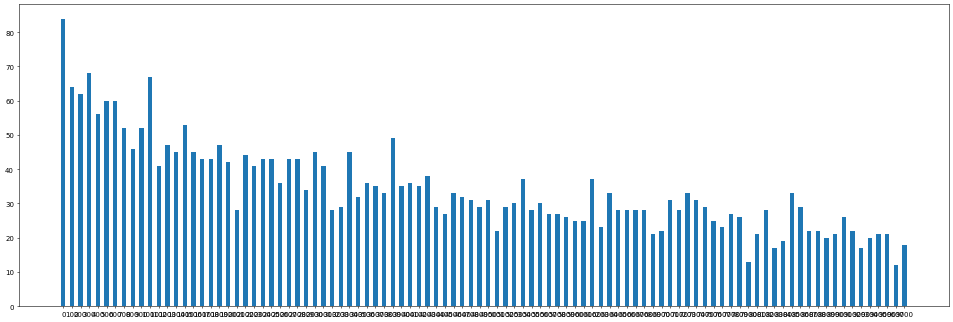

In [151]:
x = [i for i in range(0, len(label_rankings), 100)]
y = []
for i in x:
    cnt = 0
    for l in label_rankings[i:i+100]:
        if l == 8:
            cnt += 1
    y.append(cnt)

plt.figure(figsize=(24, 8), dpi=50)
plt.bar([str(i) for i in x], y, width=0.5)

In [152]:
# 人物検索 => 動作検索
mAP = 0.0
for person_idx in query_person_idx_list:
    person_query_fv = query_person_fvs[person_idx]
    # 人物の検索
    person_idx_rankings = cosine_similarity(person_query_fv, person_fvs)
    target_action_fvs = np.array([gallery_action_fvs[person_action_idxes[i]] for i in person_idx_rankings[:len(action_fvs)]])
    target_action_labels = [person_action_labels[i] for i in person_idx_rankings[:len(action_fvs)]]
    target_action_videos = [person_video_paths[i] for i in person_idx_rankings[:len(action_fvs)]]
    
    for action_idx in query_action_idx_list:
        action_query_fv = query_action_fvs[action_idx]
        # 動作検索
        action_idx_rankings = l2_similarity(action_query_fv, target_action_fvs)
        action_label_rankings = [target_action_labels[i] for i in action_idx_rankings]
        action_path_rankings = [target_action_videos[idx] for idx in action_idx_rankings]
        ap = calc_ap(int(query_action_label), action_label_rankings)
        print("Person Index : {}, Action Index  : {}, AP : {}".format(person_idx, action_idx, ap))
        print(action_label_rankings[:10])
        print(action_path_rankings[:10])
        print()
        mAP += ap
        
        if person_idx == 29 and action_idx == 0:
            break
    if person_idx == 29 and action_idx == 0:
        break
        
print("mAP : ", mAP / (len(query_person_idx_list) * len(query_action_idx_list)))

Person Index : 28, Action Index  : 0, AP : 0.05765501905130097
[99, 99, 99, 99, 99, 99, 99, 99, 99, 99]
['/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detected/shot164_1222_id_1755370.mp4', '/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detected/shot155_736_id_1655700.mp4', '/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detected/shot187_432_id_1981278.mp4', '/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detected/shot72_1498_id_811354.mp4', '/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detected/shot74_562_id_837013.mp4', '/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detected/shot109_1426_id_1182236.mp4', '/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detected/shot169_1390_id_1808241.mp4', '/net/per610a/export/das18a/satoh-lab/share/datasets/eastenders/video_detected/shot190_381_id_2010346.mp4', '/net/per610a/export/das18a/sat

<BarContainer object of 34 artists>

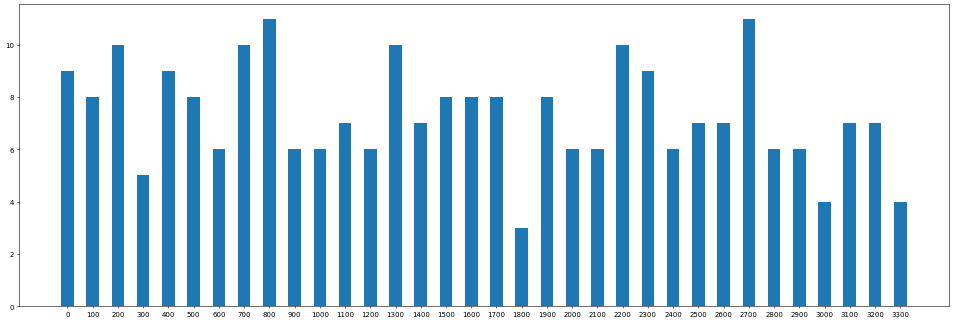

In [154]:
x = [i for i in range(0, len(action_label_rankings), 100)]
y = []
for i in x:
    cnt = 0
    for l in action_label_rankings[i:i+100]:
        if l == 1:
            cnt += 1
    y.append(cnt)

plt.figure(figsize=(24, 8), dpi=50)
plt.bar([str(i) for i in x], y, width=0.5)

In [124]:
x = [i for i in range(0, 3400, 100)]

In [128]:
y = []
for i in x:
    cnt = 0
    for l in action_label_rankings[i:i+100]:
        if l == 1:
            cnt += 1
    y.append(cnt)

In [130]:
import matplotlib.pyplot as plt

<BarContainer object of 34 artists>

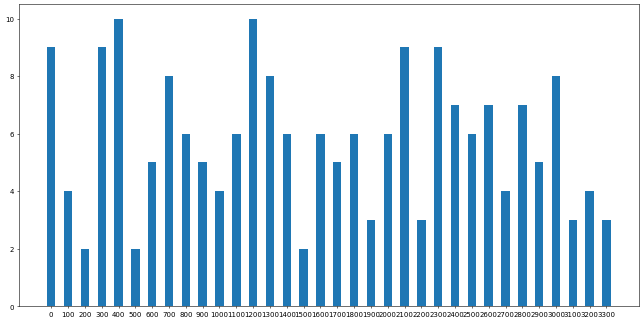

In [144]:
plt.figure(figsize=(16, 8), dpi=50)
plt.bar([str(i) for i in x], y, width=0.5)

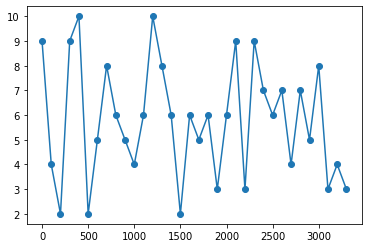

In [138]:
plt.plot(x, y, marker="o")